In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import json

if not os.path.exists(os.path.join(os.getcwd(), 'config.json')):
  # preventing to go always to the parent folder everytime we run the jupyter notebook without restarting
  os.chdir("..")
if not os.getcwd() in sys.path:
  sys.path.append(os.getcwd())

from analysis.analysis_commons import *
from strategies import *

# Main config
config = None
with open('config.json') as config_file:
  config = json.load(config_file)

In [2]:
# ---------------------------------------------------
config["database"]["database"] = "wikilite" # WIKILITE
# ---------------------------------------------------

# topic = 'Bayesian Statistics vs Frequentist Statistics'
# topic = 'Declarative Language vs Procedural Language'
topic = 'Optimism vs Pessimism'
# topic = 'Individualism vs Collectivism'

config["topic_name"] = topic

runs = 1 

with open('data/datavoids_per_topic_filtered.json', 'r') as f:
  datavoids_per_topic = json.load(f)
  check_repeated_keys(datavoids_per_topic)

  mitigator_id = datavoids_per_topic[topic]['mitigator_id']
  disinformer_id = datavoids_per_topic[topic]['disinformer_id']
  mitigator_label = label_for_topic(datavoids_per_topic[topic]['mitigator'])
  disinformer_label = label_for_topic(datavoids_per_topic[topic]['disinformer'])
  datavoids = datavoids_per_topic[topic]['datavoids']

config = clone_config_with_target(config, mitigator_label, disinformer_label, mitigator_id, disinformer_id)

config['datavoids'] = [ datavoids ]
print("Datavoids:", config['datavoids'])
keyword = config["datavoids"][0]
if isinstance(keyword, list):
  keyword = "|".join(keyword)

groups_count = prepare_db(config, force_preparation=False)
print(groups_count)

Datavoids: [['nihilism', 'affective', 'pessimism', 'depressive', 'adolescents', 'innate', 'pessimistic', 'coping', 'psychologists', 'optimism']]
Group names are the same in both databases. No further action needed.
Labeling started
Labeling opt / pes
 Target nodes: 47487167 24743
Groups count:
Groups count:
Done
{'None': 65624}


In [ ]:
disinformer_strategy = RandomStrategy(seed=42)
mitigator_strategy = RandomStrategy(seed=42)
base_output = run_simple_simulation(
  keyword, 
  mitigator_strategy, 
  disinformer_strategy, 
  'delayed_responses_base', 
  config,
  number_of_runs=runs,
  mute_output=True,
  delete_results_if_exist=True
)
config["output_filename"] = base_output
steps_per_strategy, strategies, id_max_rank = get_output(config)
plot_results_for_steps_per_strategy(
  strategies[0], 
  steps_per_strategy, 
  config, 
  filter_groups=['None']
)

In [ ]:
delayed_response_steps = 10
max_steps = min([c for _, c in groups_count.items()])
# max_steps = 40
step_increment = max(1, max_steps // delayed_response_steps)
# step_increment = 4
print("steps increment:", step_increment)
steps_delay = step_increment 
delayed_response_step = 0
outputs = {}
while steps_delay < max_steps:

  #TODO remove, it's for debugging only the first steps
  # if delayed_response_step > 4:
  #   break

  print('Delayed response step', delayed_response_step)
  print('Steps delay', steps_delay)

  group = config['mitigator_keyword']
  opponent_group = config['disinformer_keyword']
  def stop_if_greater(agent): 
    _, wavgrank_val = top_k_group_analysis(agent.graph, config)
    our_val = wavgrank_val[group]
    other_val = wavgrank_val[opponent_group]
    if our_val > other_val:
      return True
    return False

  def stop_after_delay(agent):
    return agent.steps_count > steps_delay

  disinformer_strategy = ConditionalEndStrategy(
    RandomStrategy(), 
    stop_after_delay
  )
  # disinformer_strategy = RandomStrategy(seeded=True)

  mitigator_strategy = DelayedStartStrategy(
    ConditionalEndStrategy(
      # OptimalRankAndCostsStrategy(horizon=1, alpha=0.5),
      # OptimalCostsStrategy(),
      GreedyStrategy(),
      stop_if_greater
    ), 
    steps_delay)
    # 110)

  outputs["delayed" + str(steps_delay)] = {
    "filename": run_simple_simulation(
                keyword, 
                mitigator_strategy, 
                disinformer_strategy, 
                'delayed_responses_step' + str(steps_delay), 
                config,
                mute_output=True,
                number_of_runs=runs,
                delete_pagerank=False,
                delete_results_if_exist=True
              ),
    "delay": steps_delay
  }

  steps_delay += step_increment
  delayed_response_step += 1

Remember that the differences are calculated as test values - opponent's test values for the dark line, and base values - opponent's base values for the more transparent line
Meaning: opt  -  pes
Area weighted avg rank: {'area_opt': 0.571875346875347, 'area_pes': 29.911530136530132, 'steps_above': {'opt': 2, 'pes': 14}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 0.12099999999999998, 'steps_above': {'opt': 0, 'pes': 16}}


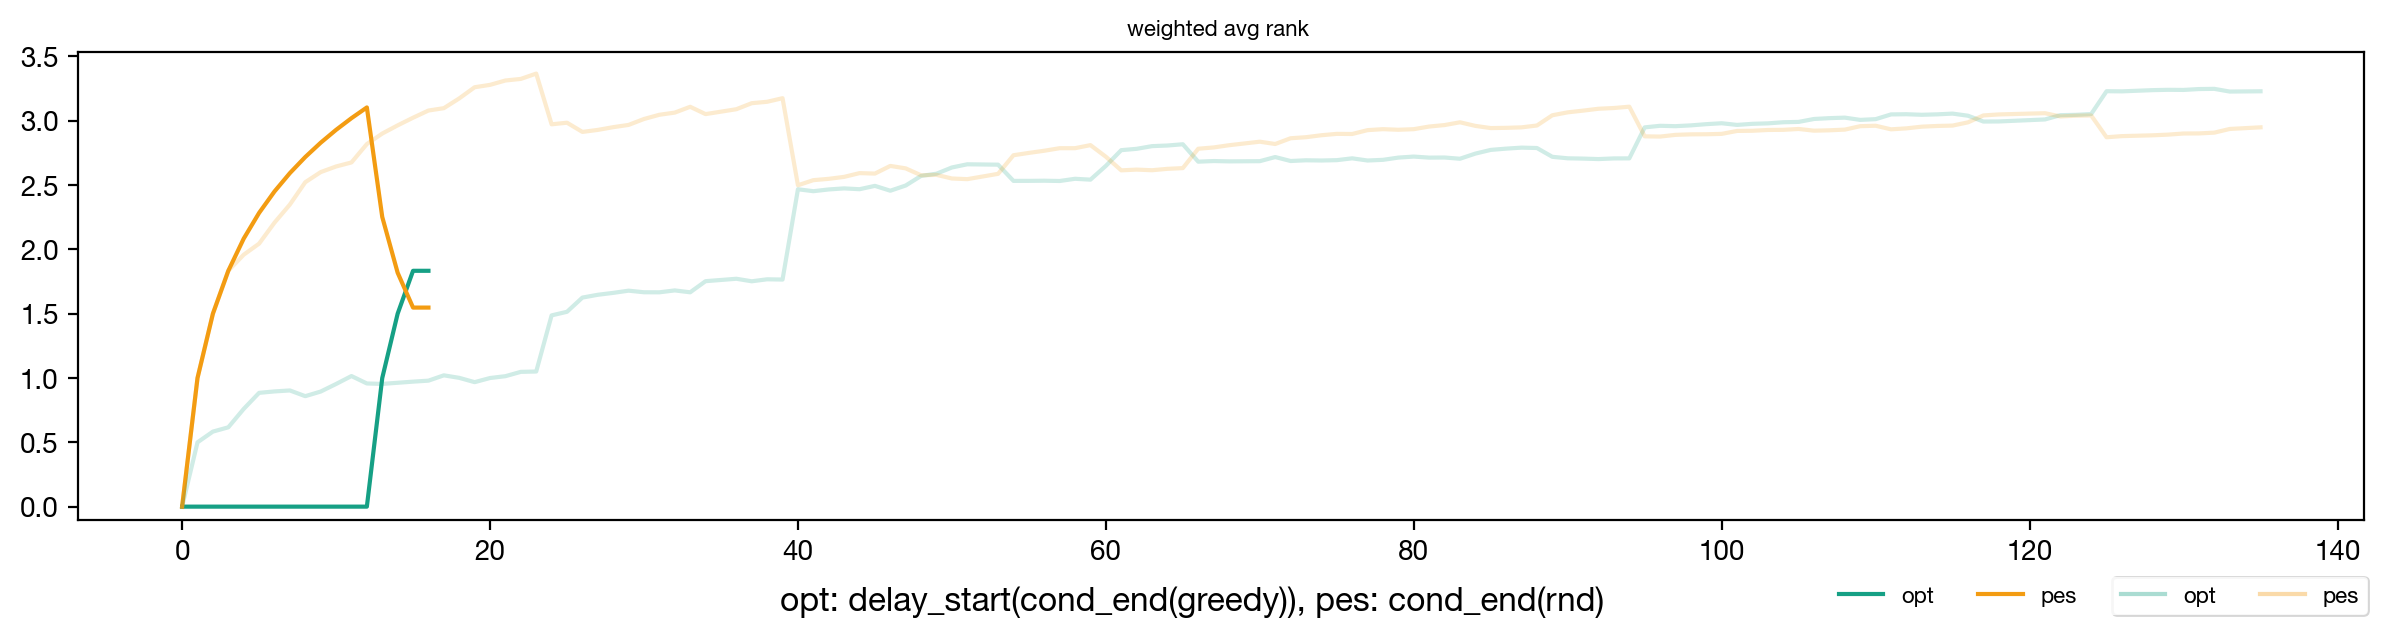

Area weighted avg rank: {'area_opt': 0.2544381805555309, 'area_pes': 78.7174265377536, 'steps_above': {'opt': 2, 'pes': 30}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 0.4800000000000002, 'steps_above': {'opt': 0, 'pes': 32}}


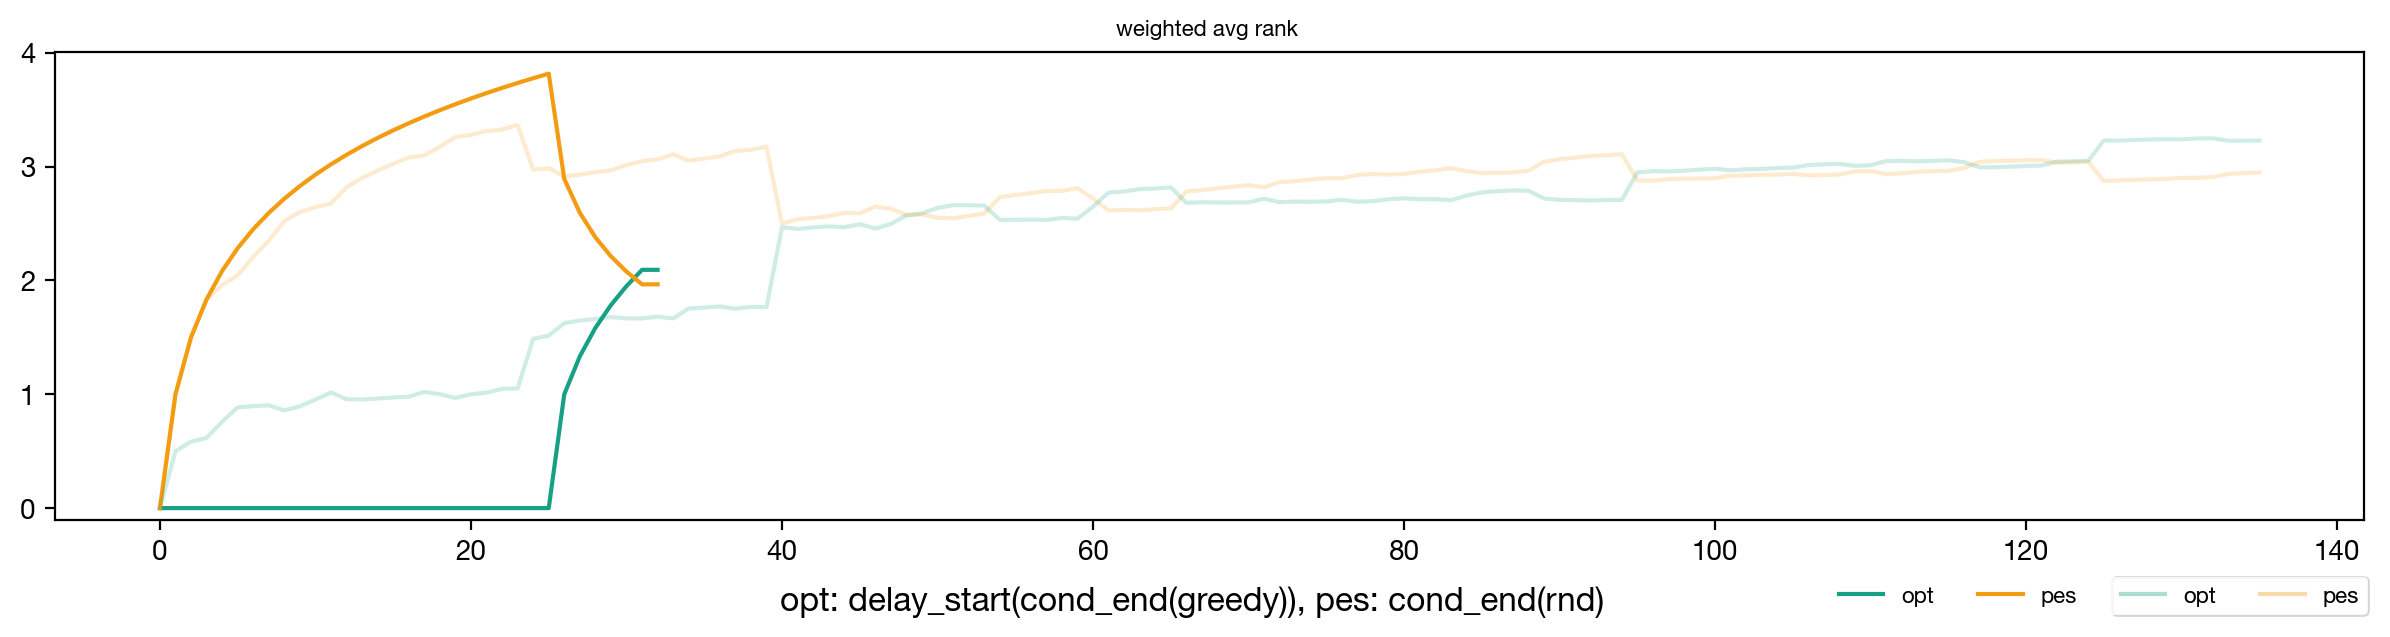

Area weighted avg rank: {'area_opt': 0.38788154667513286, 'area_pes': 131.31306293421065, 'steps_above': {'opt': 2, 'pes': 42}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 0.9550000000000006, 'steps_above': {'opt': 0, 'pes': 44}}


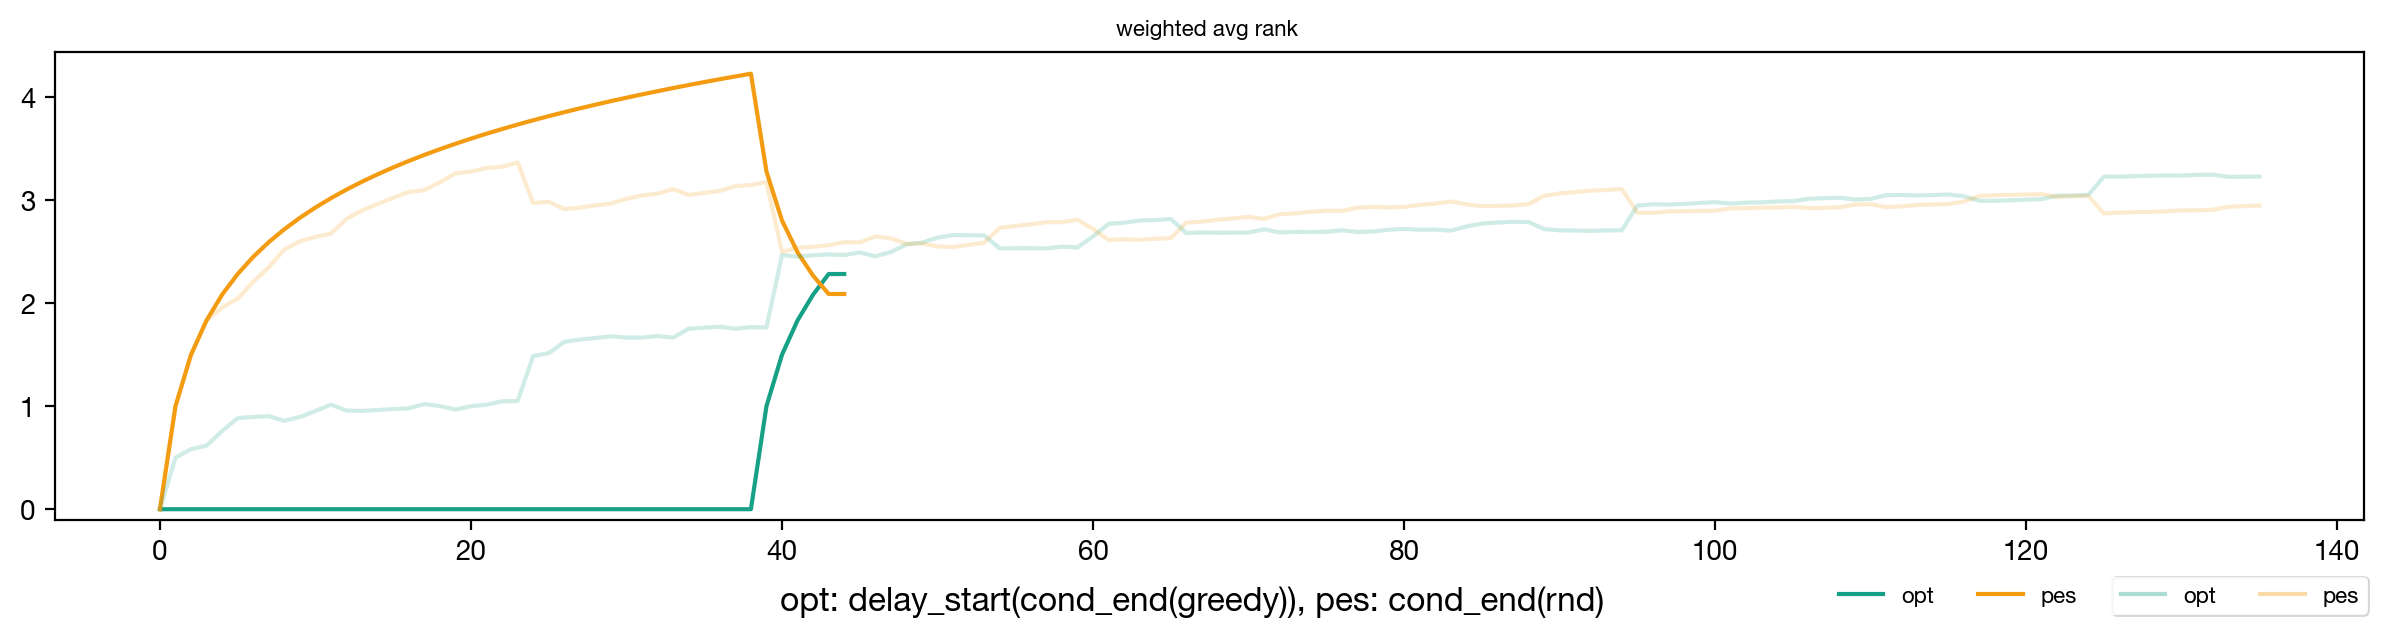

Area weighted avg rank: {'area_opt': 0.09569578153534142, 'area_pes': 195.64867708805338, 'steps_above': {'opt': 2, 'pes': 66}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 2.0580000000000003, 'steps_above': {'opt': 0, 'pes': 68}}


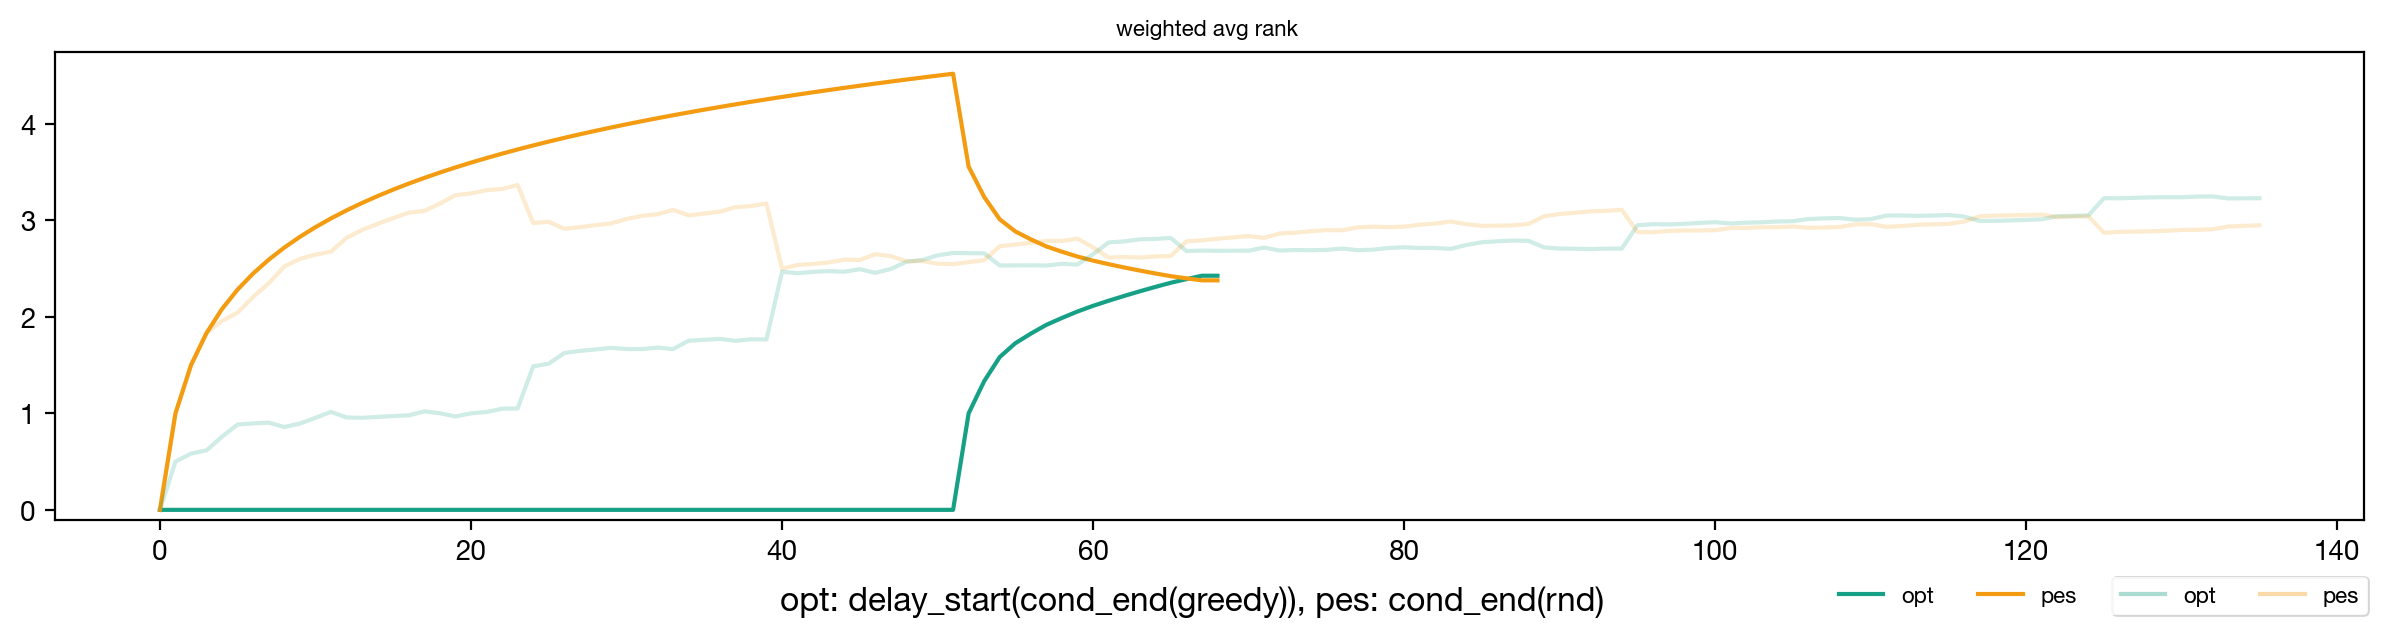

Area weighted avg rank: {'area_opt': 0.12787160631888117, 'area_pes': 255.00339831258705, 'steps_above': {'opt': 2, 'pes': 74}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 2.7830000000000004, 'steps_above': {'opt': 0, 'pes': 76}}


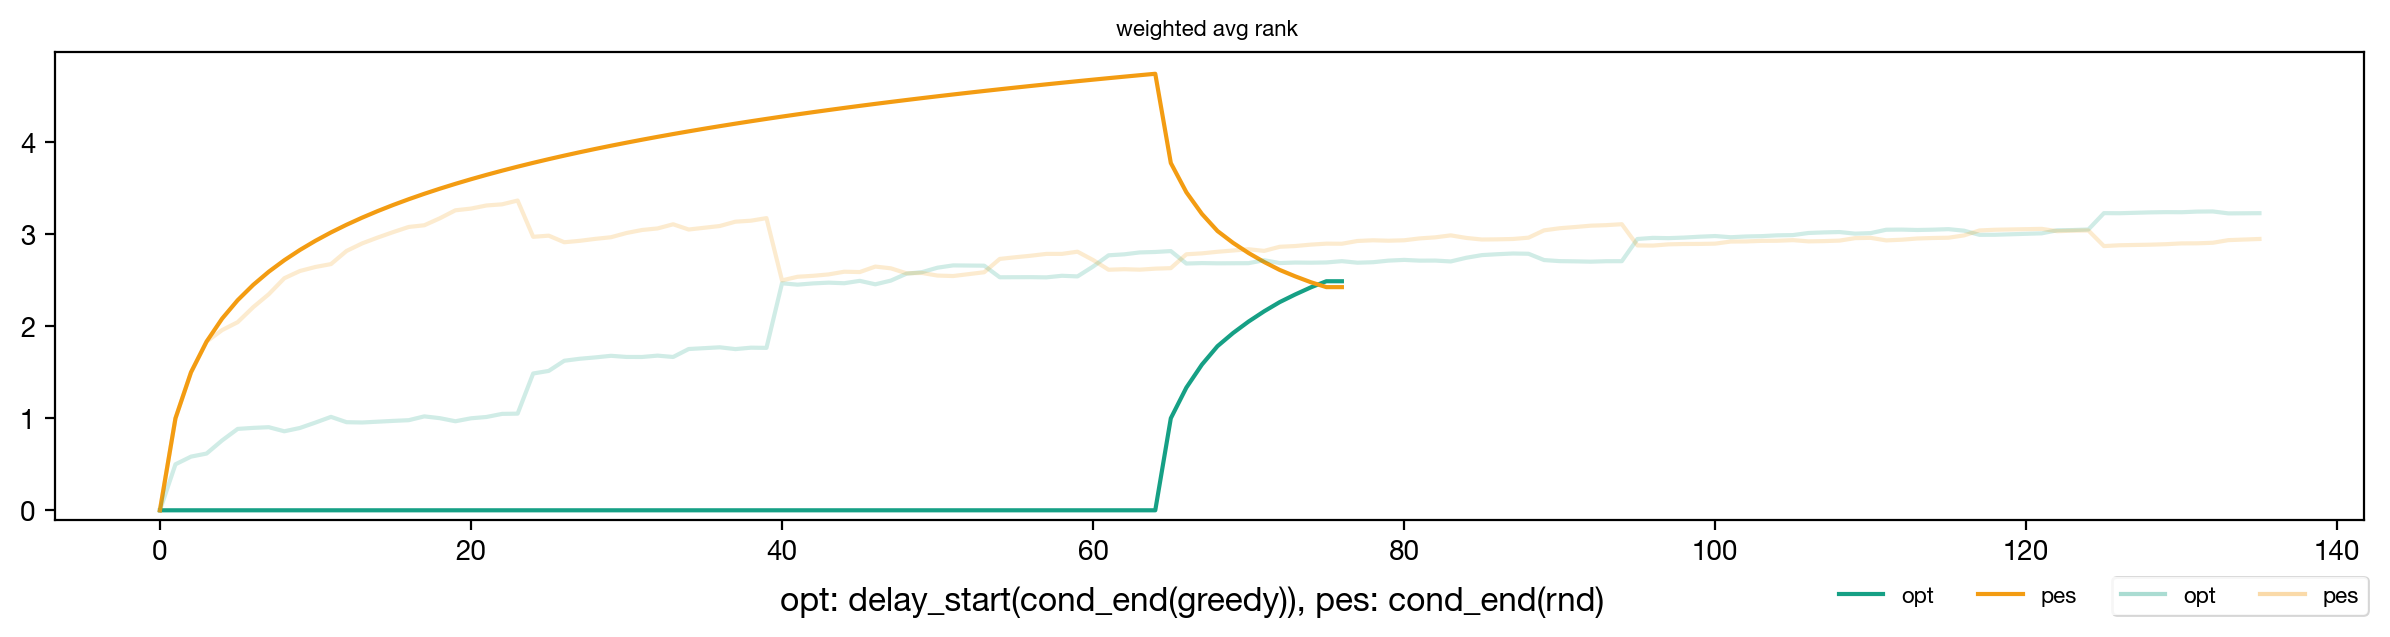

Area weighted avg rank: {'area_opt': 0.0022784902571437726, 'area_pes': 326.3266913316122, 'steps_above': {'opt': 2, 'pes': 100}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 4.629000000000001, 'steps_above': {'opt': 0, 'pes': 102}}


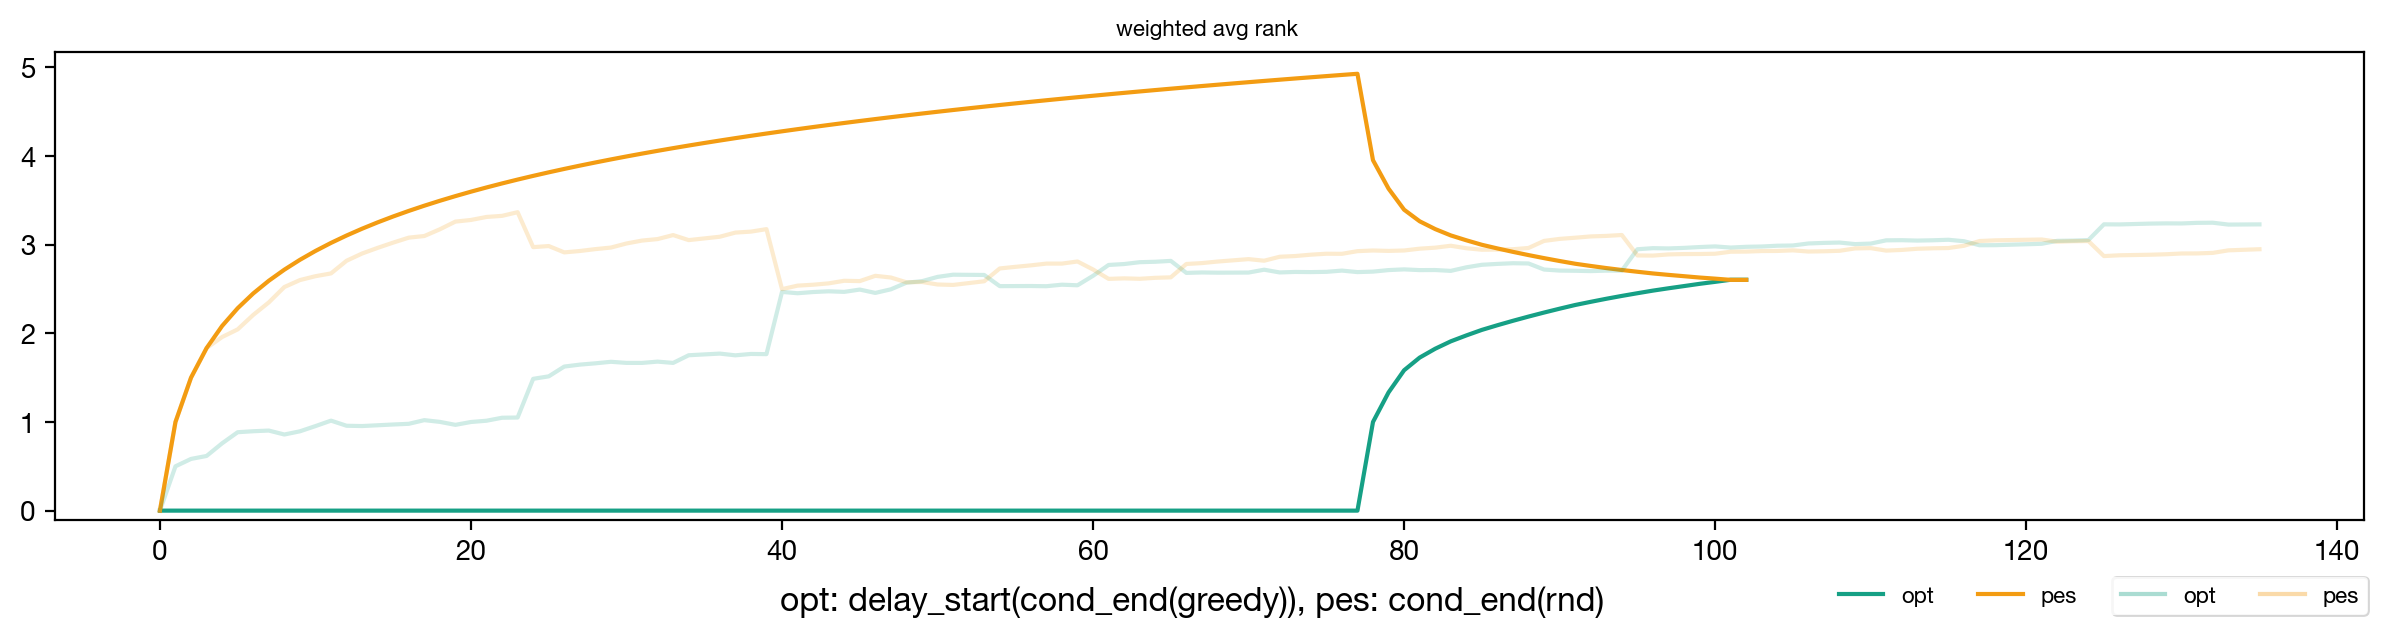

Area weighted avg rank: {'area_opt': 0.12468483110581641, 'area_pes': 383.39350579016457, 'steps_above': {'opt': 2, 'pes': 102}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 5.2650000000000015, 'steps_above': {'opt': 0, 'pes': 104}}


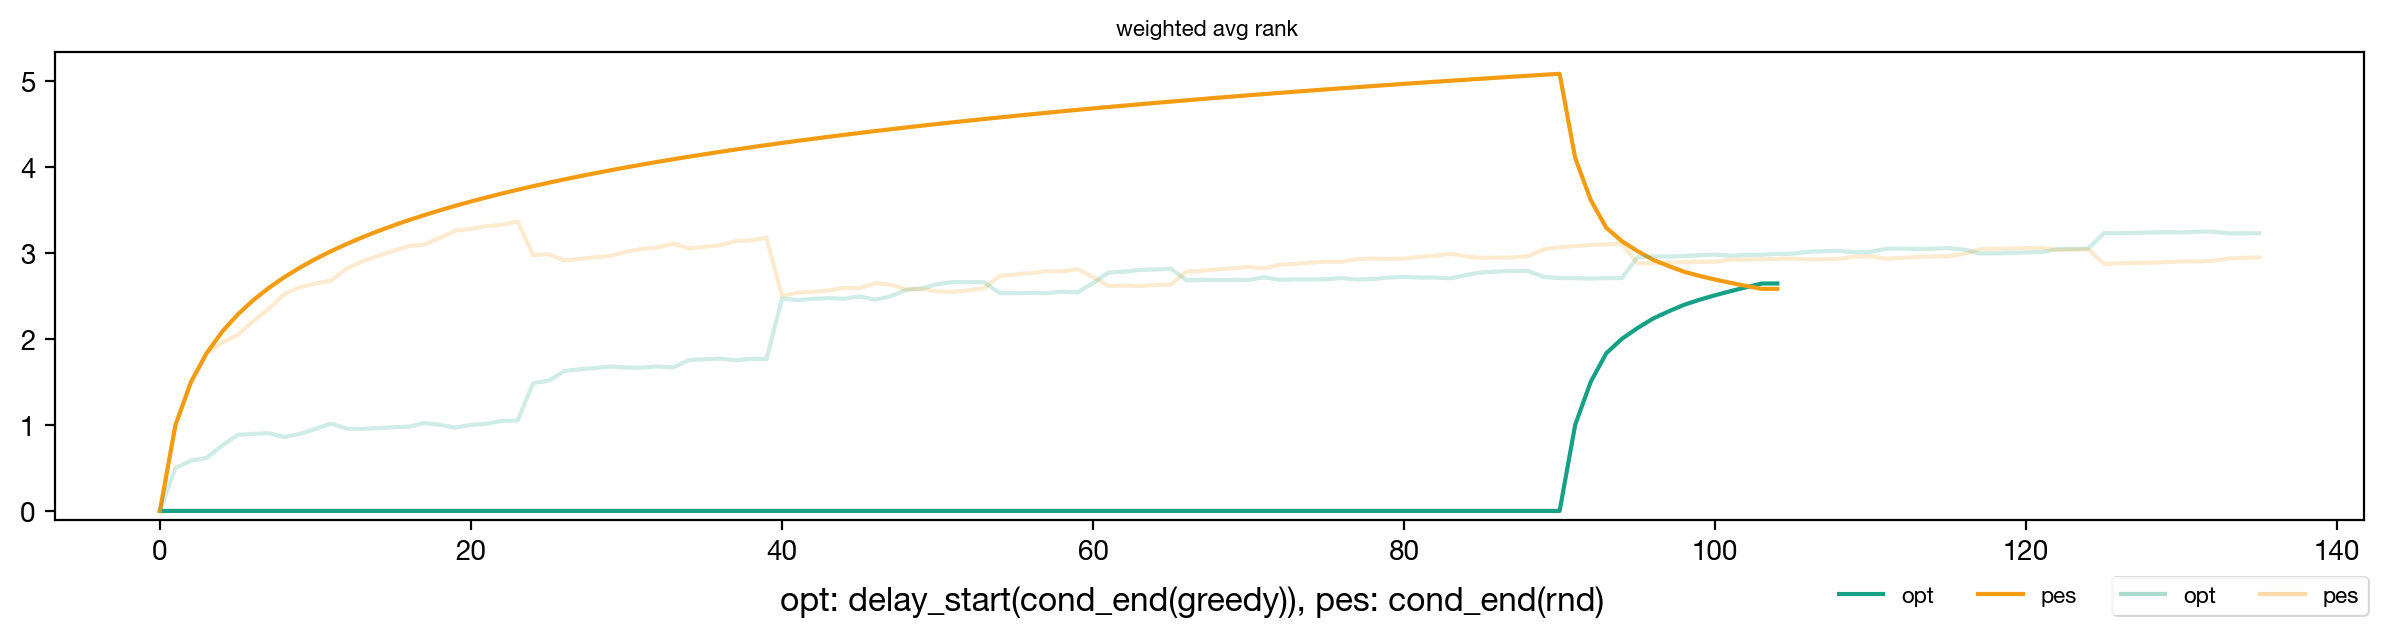

Area weighted avg rank: {'area_opt': 0.07907621296205392, 'area_pes': 453.37251335377323, 'steps_above': {'opt': 2, 'pes': 120}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 7.143000000000002, 'steps_above': {'opt': 0, 'pes': 122}}


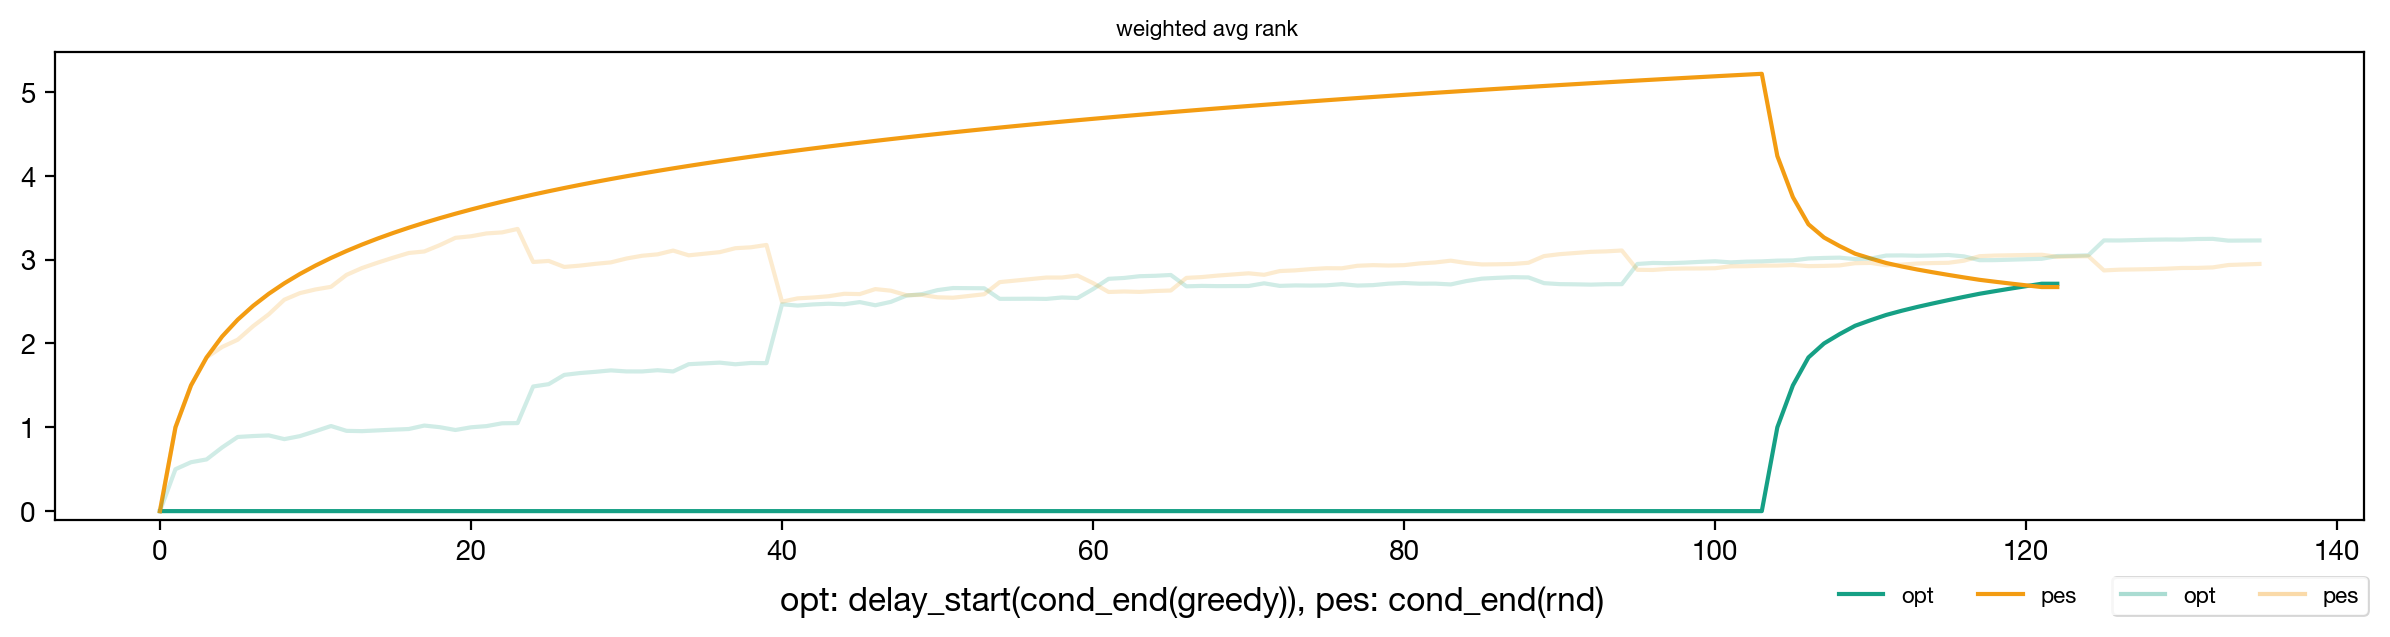

Area weighted avg rank: {'area_opt': 0.010118189143369705, 'area_pes': 542.3266289928173, 'steps_above': {'opt': 2, 'pes': 163}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 11.295000000000003, 'steps_above': {'opt': 0, 'pes': 165}}


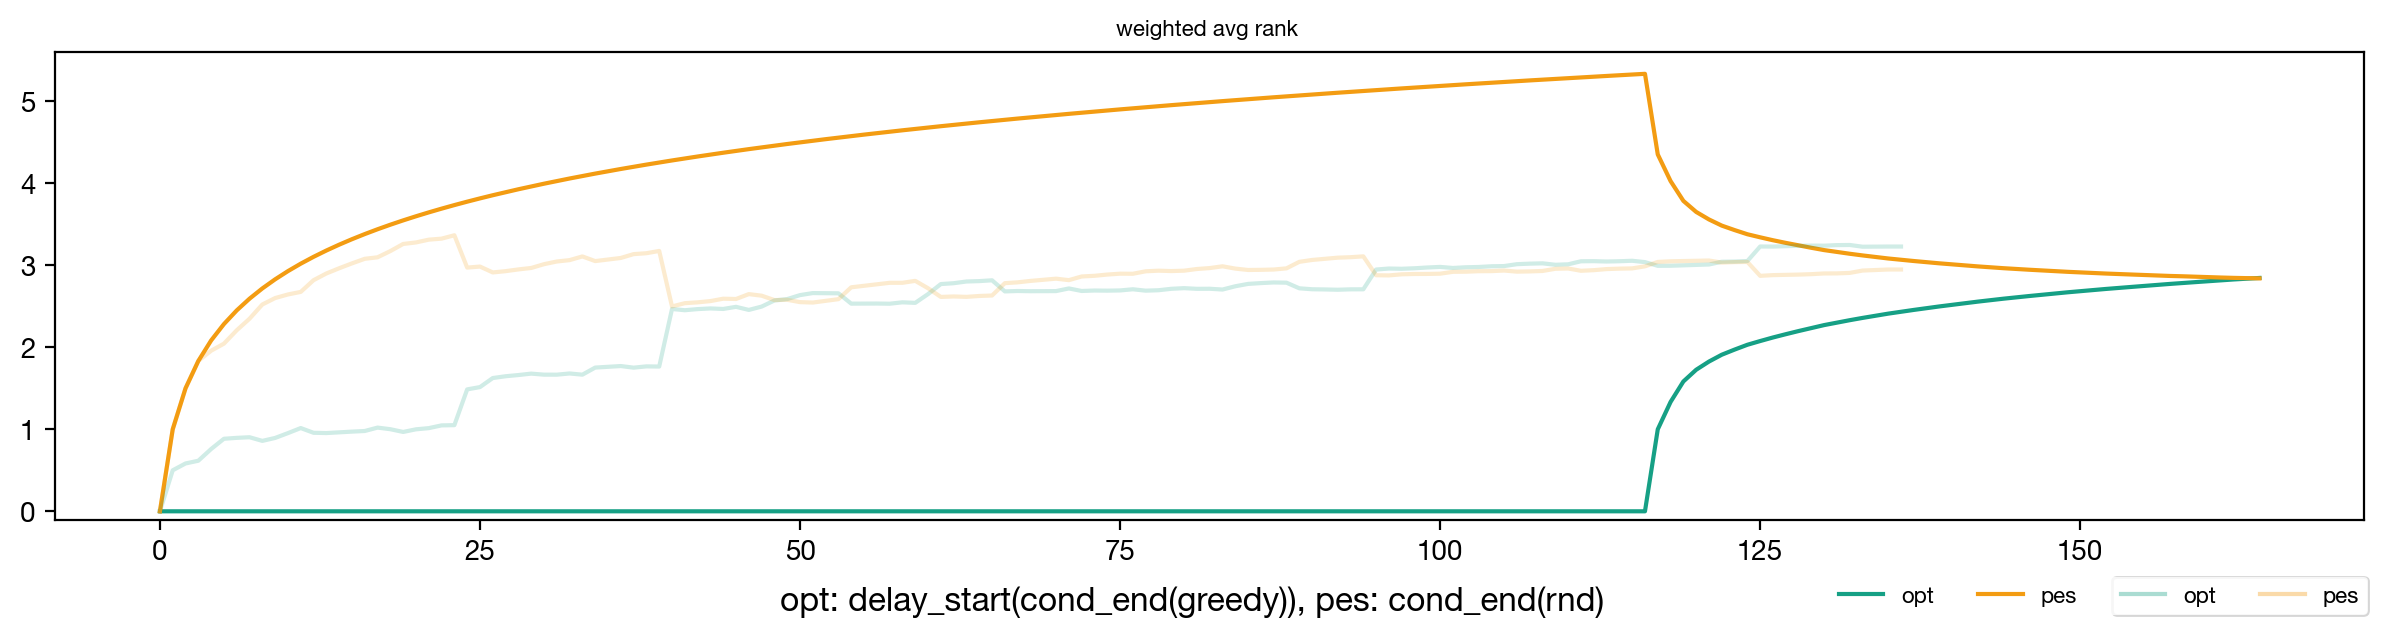

Area weighted avg rank: {'area_opt': 0.002521917887193581, 'area_pes': 620.7743727031577, 'steps_above': {'opt': 2, 'pes': 195}}
Area nodes in top k: {'area_opt': 0, 'area_pes': 14.880000000000004, 'steps_above': {'opt': 0, 'pes': 197}}


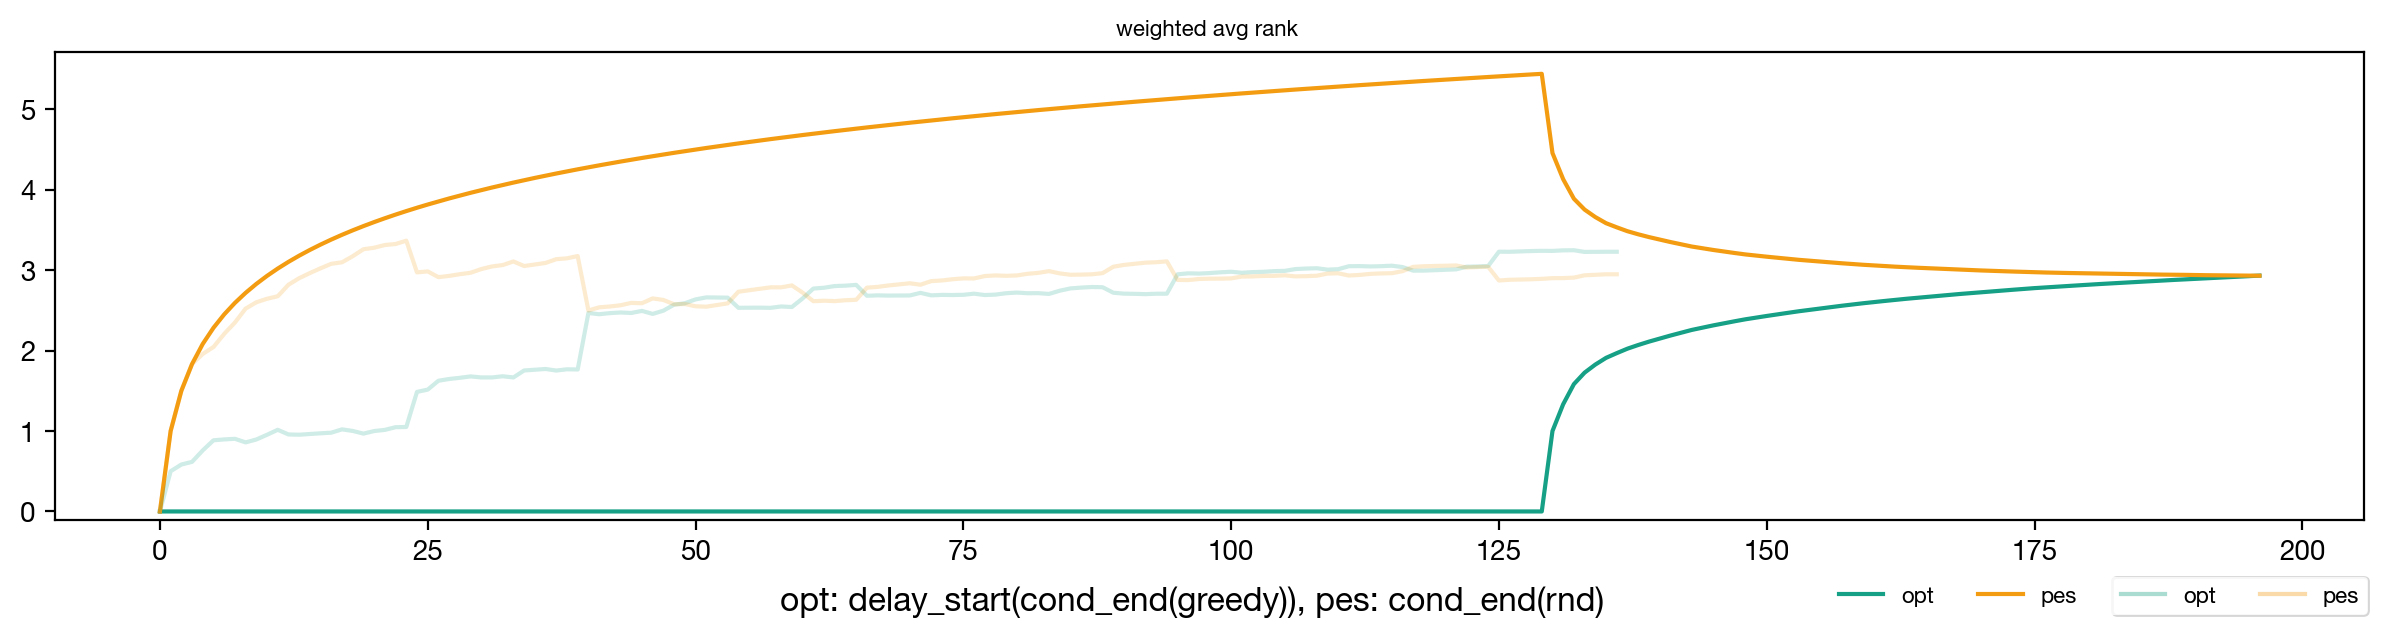

In [ ]:
config["output_filename"] = base_output
config["topic_name"] = topic
config["target_groups"] = [mitigator_label, disinformer_label, 'None']

steps_per_strategy_base, strategies_base, id_max_rank_base = get_output(config)

print("Remember that the differences are calculated as test values - opponent's test values for the dark line, and base values - opponent's base values for the more transparent line")
print("Meaning:", config['target_groups'][0], " - ", config['target_groups'][1])

results_per_delay = {}

max_steps = max(steps_per_strategy_base[strategies_base[0]].keys())

i = 0
for output in outputs.values():
  config["output_filename"] = output["filename"]
  steps_per_strategy, strategies, id_max_rank = get_output(config)

  steps_no = min(
    max(steps_per_strategy[strategies[0]].keys()),
    max(steps_per_strategy_base[strategies_base[0]].keys())
  )

  areas = calculate_area_for_steps_per_strategy(strategies[0], steps_per_strategy, config)

  results_per_delay[i] = areas
  results_per_delay[i]['delay'] = output["delay"]
  results_per_delay[i]['costs'] = { gr: 0 for gr in config["target_groups"] }
  results_per_delay[i]['nodes_added'] = { gr: 0 for gr in config["target_groups"] }

  for g in config["target_groups"]:
    last_step = max(list(steps_per_strategy[strategies[0]].keys()))
    costs_vals = steps_per_strategy[strategies[0]][last_step][g]["cost"]
    nodes_vals = steps_per_strategy[strategies[0]][last_step][g]["nodes_added"]
    results_per_delay[i]['nodes_added'][g] = sum(nodes_vals) / len(nodes_vals)
    results_per_delay[i]['costs'][g] = sum(costs_vals) / len(costs_vals)

  print("Area weighted avg rank:", areas['weighted_avg_rank'])
  print("Area nodes in top k:", areas['nodes_in_top_k'])
  plot_results_for_steps_per_strategy_and_base(
    strategies[0], 
    strategies_base[0], 
    steps_per_strategy,
    steps_per_strategy_base,
    config,
    # max_x=max_steps
  )

  # plot_costs(
  #   strategies[0], 
  #   steps_per_strategy, 
  #   config,
  #   filter_groups=['None'],
  #   steps_no=steps_no,
  #   max_x=max_steps
  # )
  # plot_nodes_added(
  #   strategies[0], 
  #   steps_per_strategy, 
  #   config,
  #   filter_groups=['None'],
  #   steps_no=steps_no,
  #   max_x=max_steps
  # )

  # plot_differences_against_opponent_base(
  #   'Delayed differences (' + str(i) + ')',
  #   config['target_groups'][0],
  #   config['target_groups'][1],
  #   strategies_base[0],
  #   strategies[0],
  #   steps_per_strategy_base, 
  #   steps_per_strategy, 
  #   config,
  #   steps_no=steps_no
  # )

  i += 1
  # break

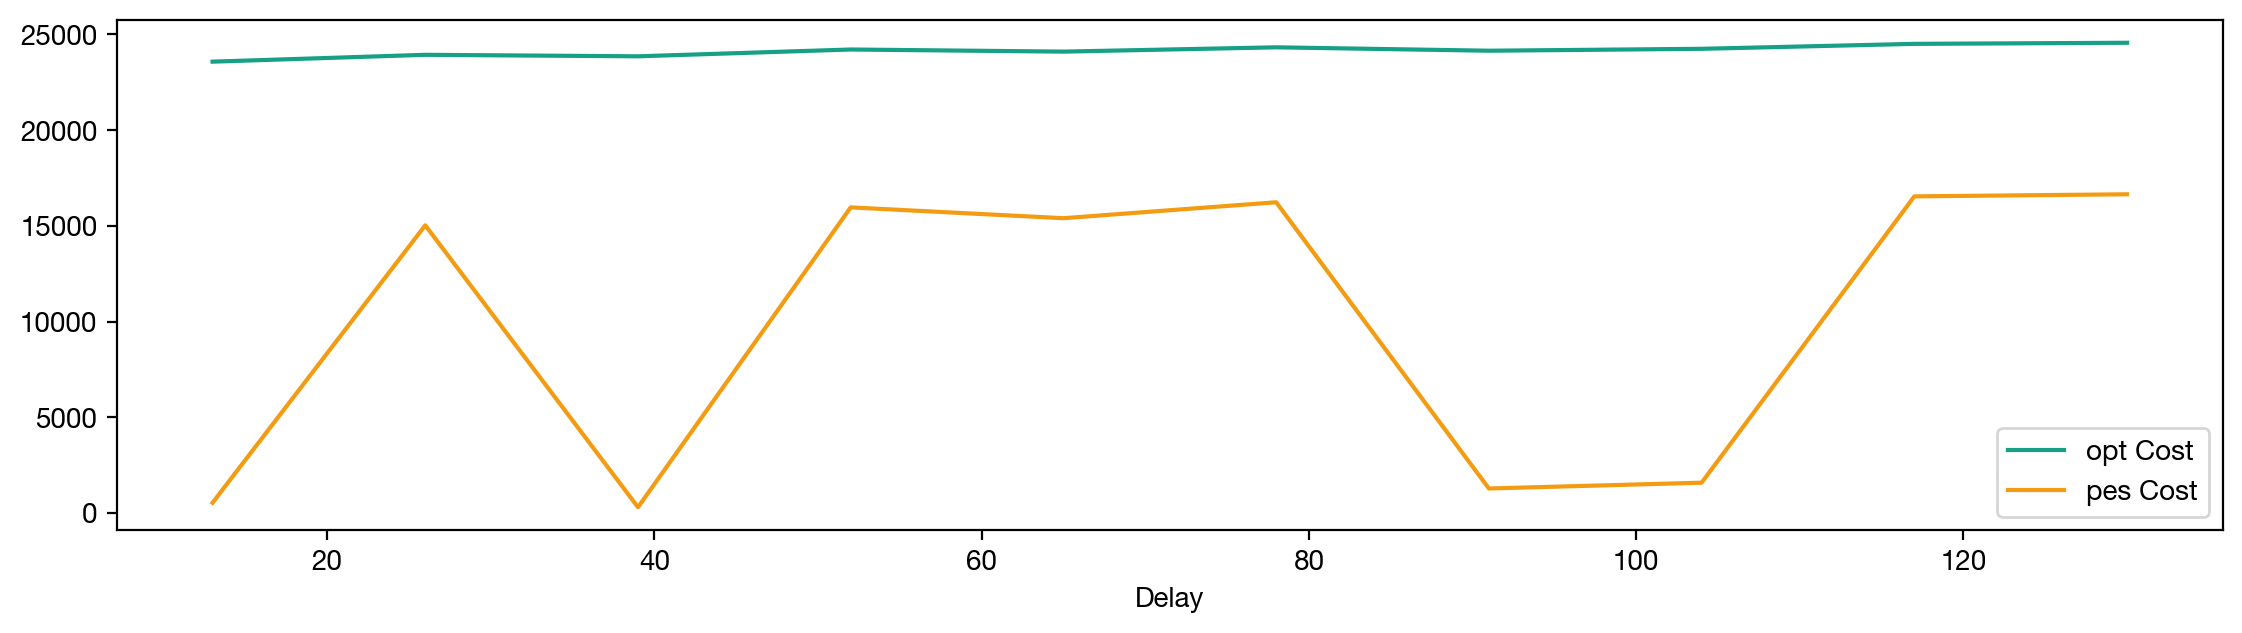

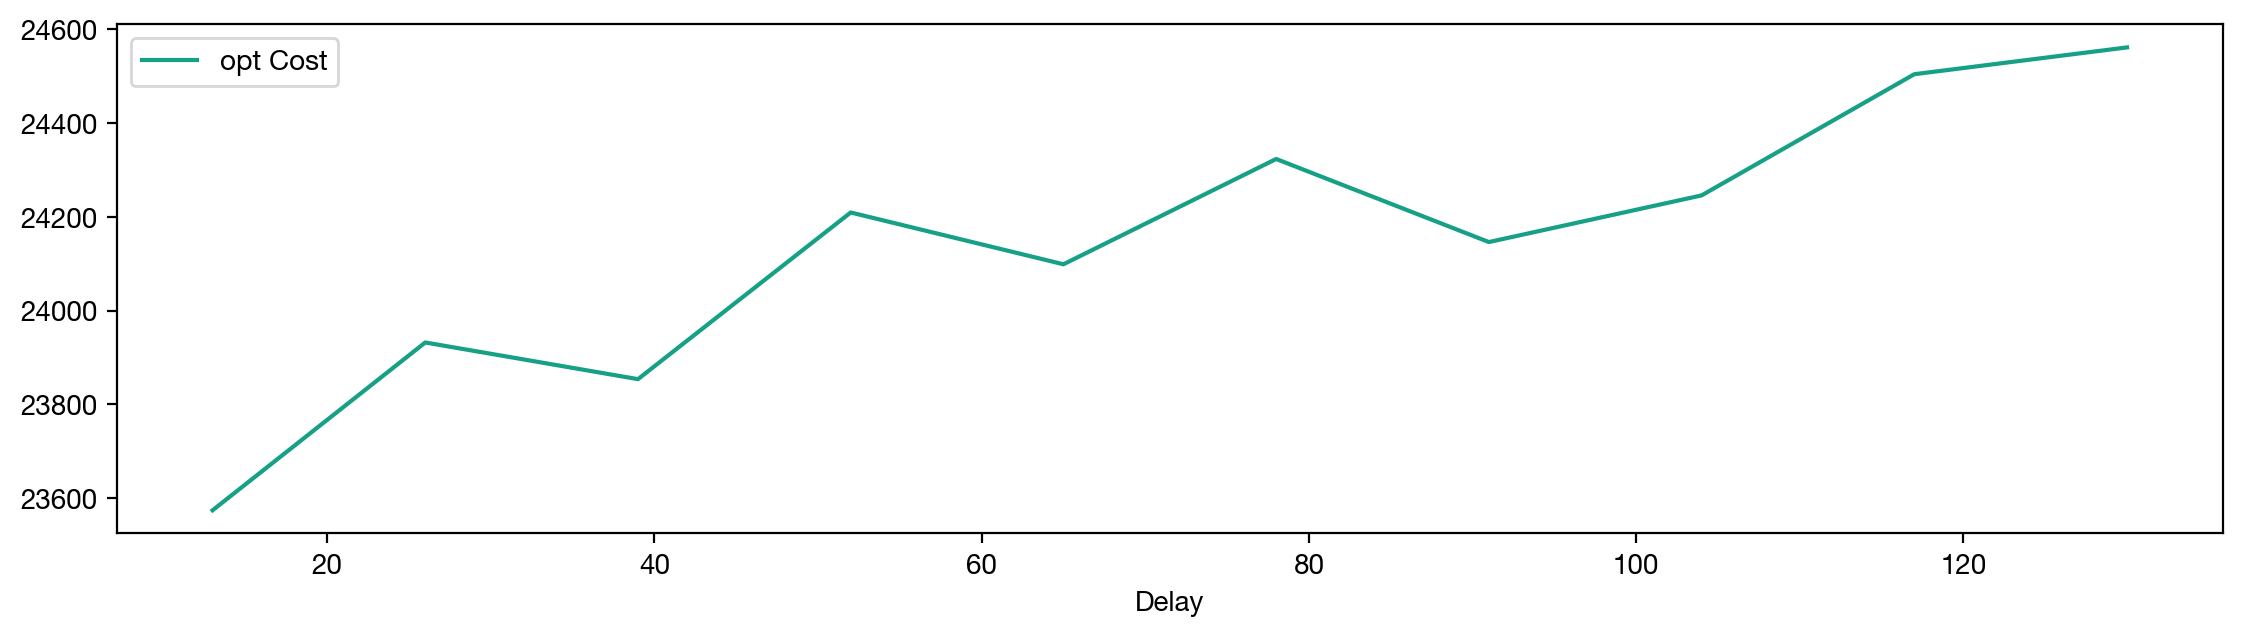

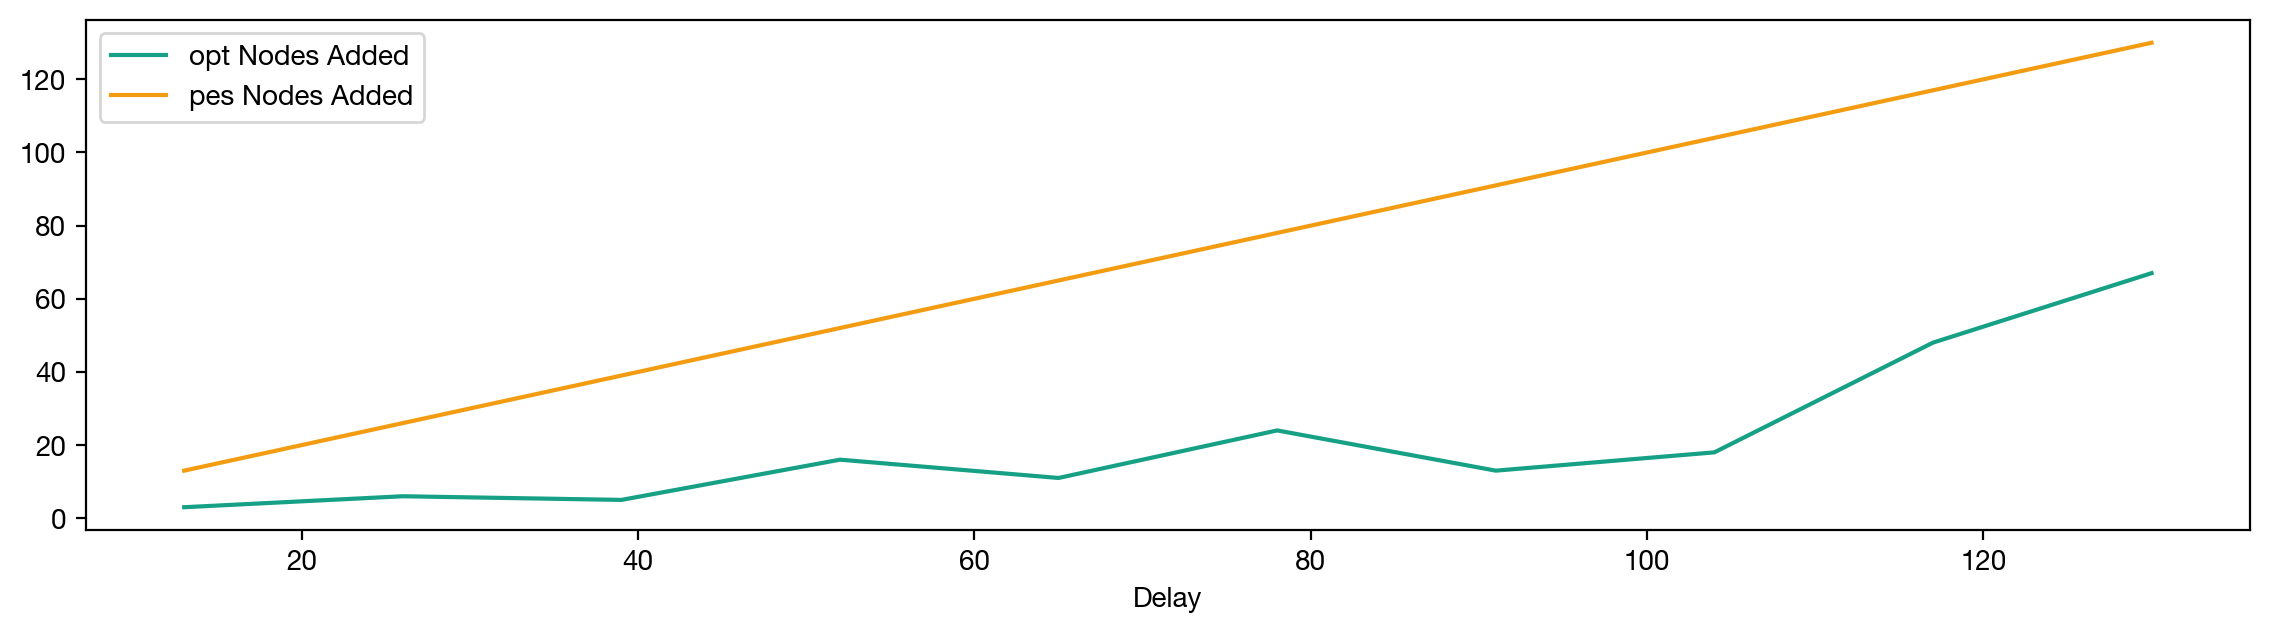

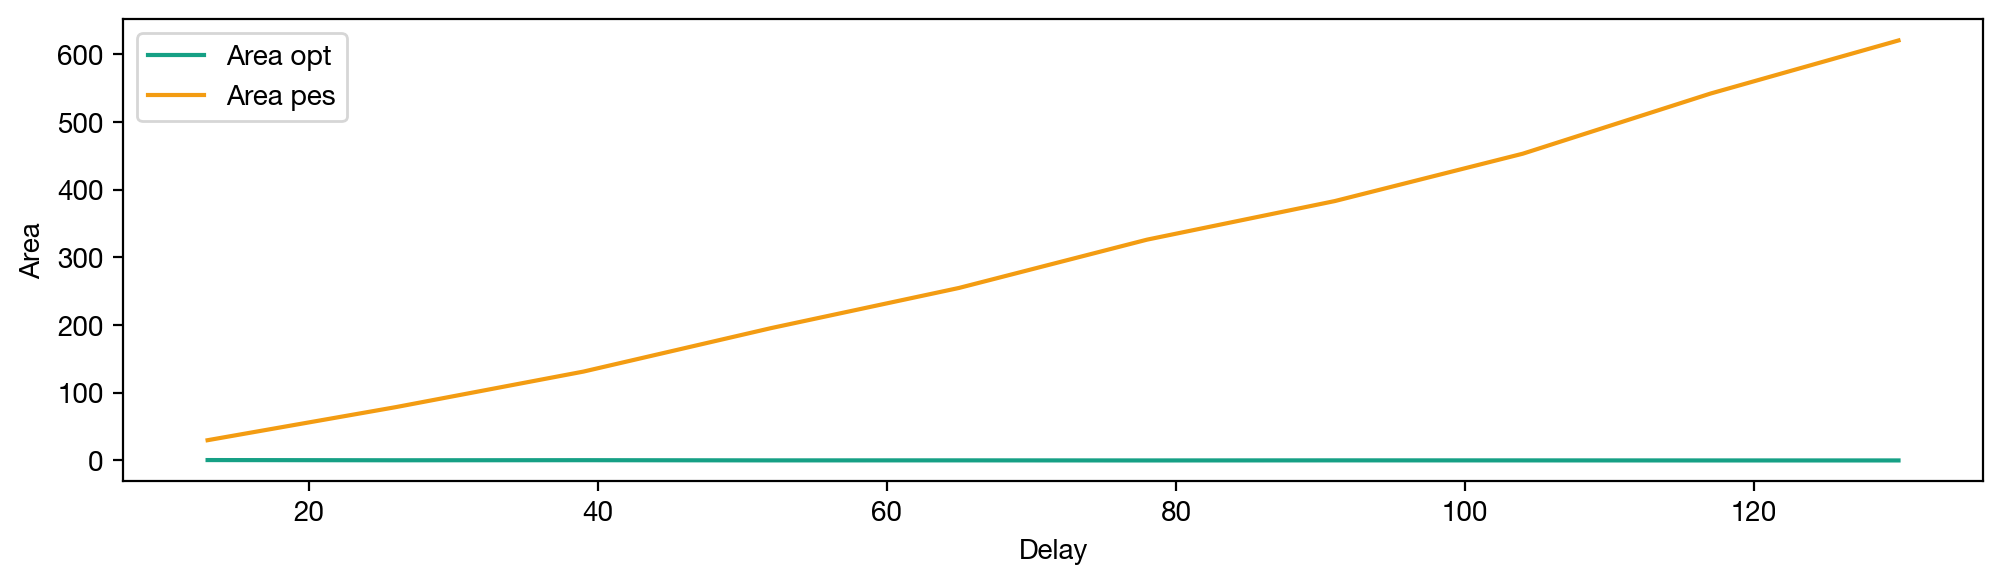

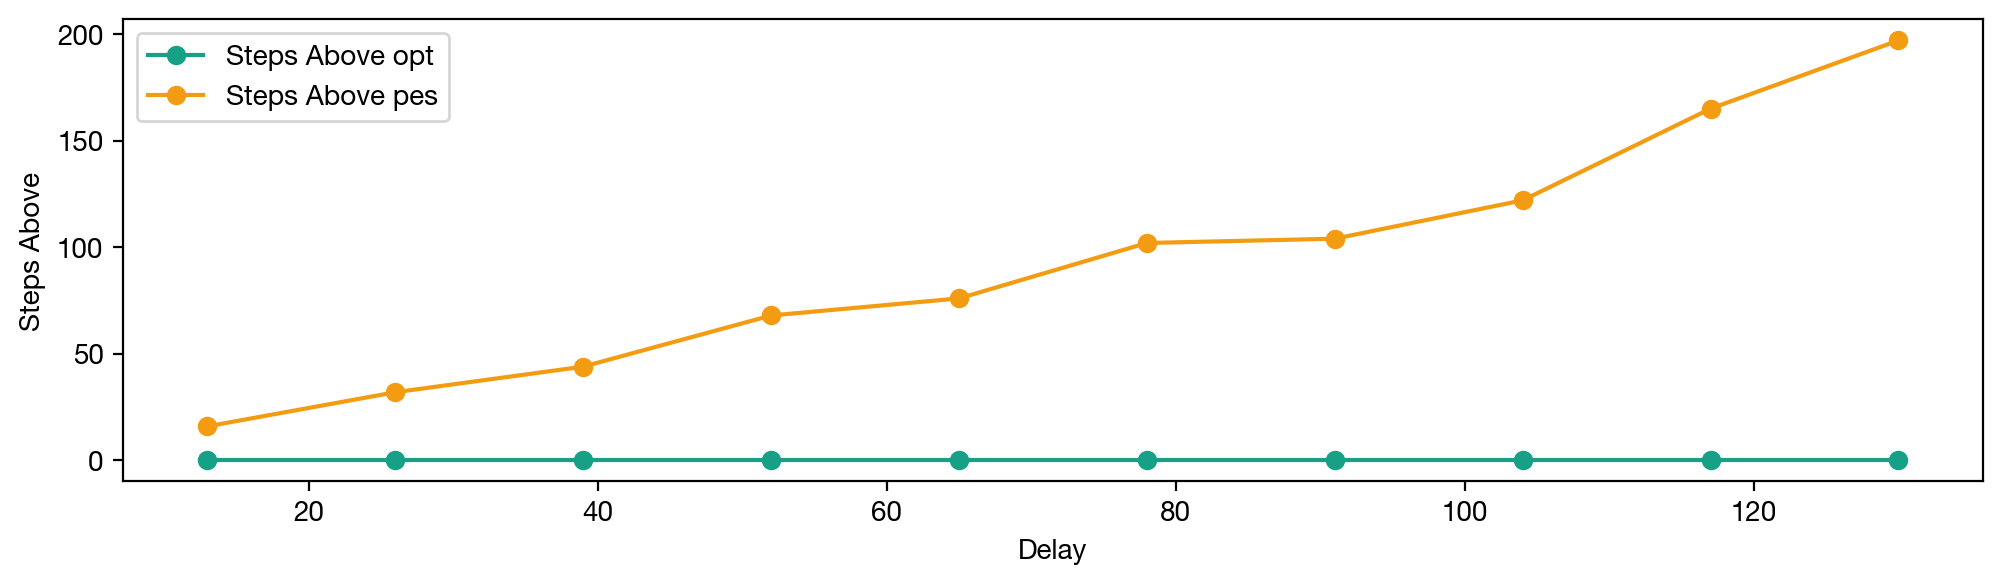

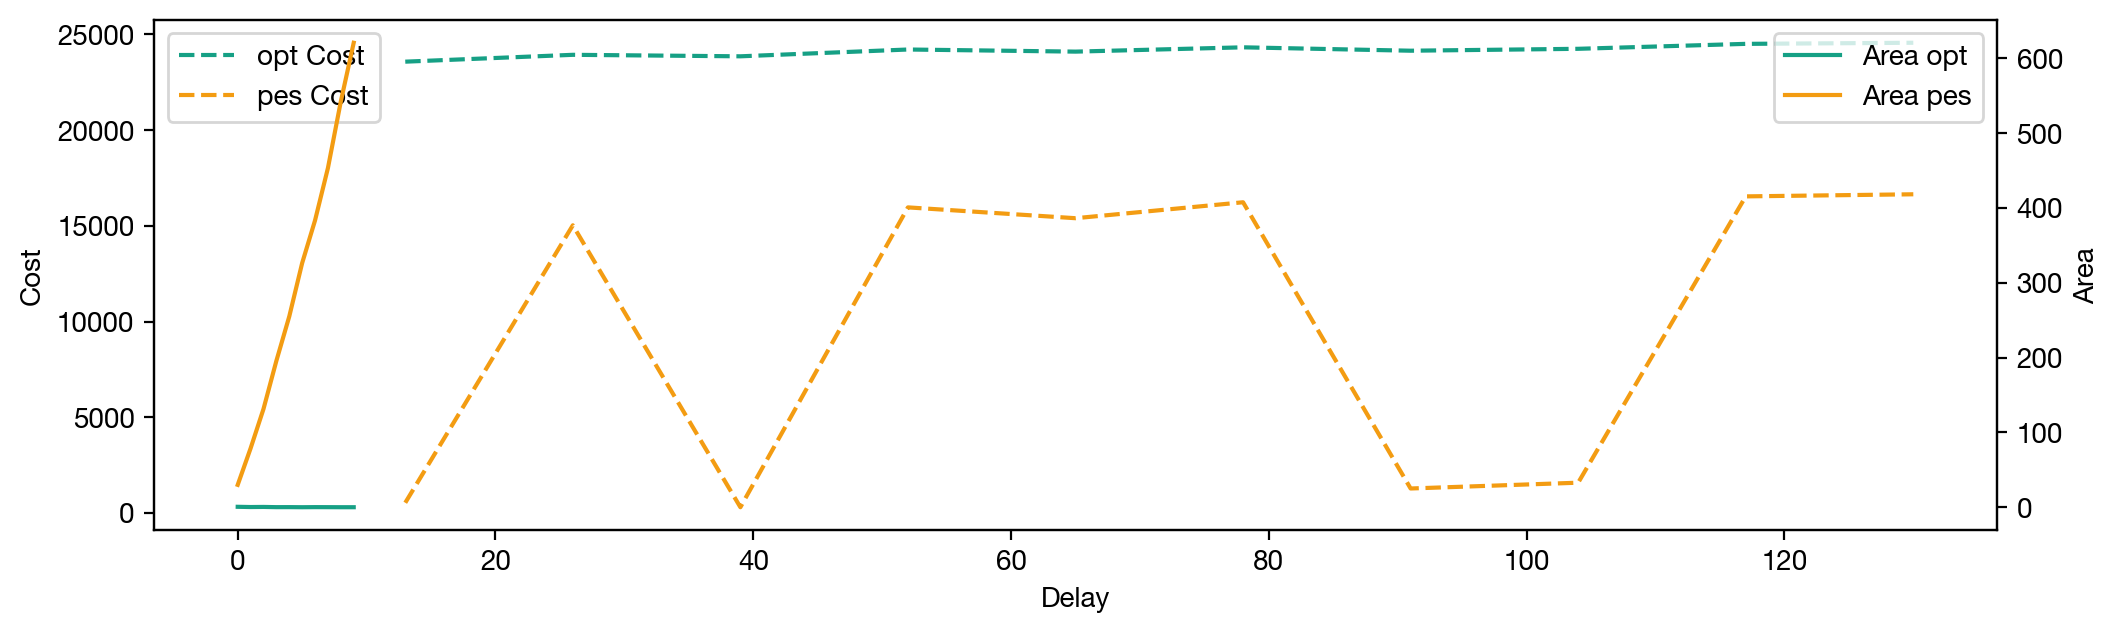

In [ ]:
def generate_plots(results_per_delay, config):
    target_groups = list(filter(lambda v: v != 'None', config["target_groups"]))

    # Initialize data structures
    keys = list(results_per_delay.keys())
    delays = [results_per_delay[k]['delay'] for k in keys]
    costs = {group: [results_per_delay[k]['costs'][group] for k in keys] for group in target_groups}
    nodes_added = {group: [results_per_delay[k]['nodes_added'][group] for k in keys] for group in target_groups}
    areas = {group: [results_per_delay[k]['weighted_avg_rank']['area_' + group] for k in keys] for group in target_groups}
    steps_above = {group: [results_per_delay[k]['nodes_in_top_k']['steps_above'][group] for k in keys] for group in target_groups}

    # Plot for costs
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Delay')
    for group in target_groups:
        ax1.plot(delays, costs[group], color=config["groups_colors"][group], label=f'{group} Cost')
    ax1.legend()
    fig.tight_layout()
    fig.set_size_inches(12, 3)
    plt.show()

    # Plot for costs only for mitigator
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Delay')
    for group in target_groups:
      if group == config['target_groups'][0]:
        ax1.plot(delays, costs[group], color=config["groups_colors"][group], label=f'{group} Cost')
    ax1.legend()
    fig.tight_layout()
    fig.set_size_inches(12, 3)
    plt.show()

    # Plot for nodes_added
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Delay')
    for group in target_groups:
        ax1.plot(delays, nodes_added[group], color=config["groups_colors"][group], label=f'{group} Nodes Added')
    ax1.legend()
    fig.tight_layout()
    fig.set_size_inches(12, 3)
    plt.show()

    # Plot for areas
    fig, ax = plt.subplots()
    for group in target_groups:
        ax.plot(delays, areas[group], label=f'Area {group}', color=config["groups_colors"][group])
    ax.set_xlabel('Delay')
    ax.set_ylabel('Area')
    ax.legend()
    fig.set_size_inches(12, 3)
    plt.show()

    # Plot for steps above
    fig, ax = plt.subplots()
    for group in target_groups:
        ax.plot(delays, steps_above[group], label=f'Steps Above {group}', marker='o', color=config["groups_colors"][group])
    ax.set_xlabel('Delay')
    ax.set_ylabel('Steps Above')
    ax.legend()
    fig.set_size_inches(12, 3)
    plt.show()

    # Combined plot for costs and areas
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Delay')
    ax1.set_ylabel('Cost')
    for group in target_groups:
        ax1.plot(delays, costs[group], color=config["groups_colors"][group], linestyle='--', label=f'{group} Cost')
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Area')
    for group in target_groups:
        ax2.plot(keys, areas[group], color=config["groups_colors"][group], label=f'Area {group}')
    ax2.legend(loc='upper right')
    fig.tight_layout()
    fig.set_size_inches(12, 3)
    plt.show()

generate_plots(results_per_delay, config)